In [1]:
from functions import *
from process_text import *
from sklearn.metrics import confusion_matrix
from nltk.corpus import stopwords
import sklearn
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report
import random
from sklearn.model_selection import cross_validate as cvt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from copy import deepcopy as dp

In [2]:
test, train = load_pkl(r'C:\Users\HEndo\Documents\GitHub\zemi\cleaned_corpus\base_cleaned.pkl')
test_a, train_a = load_pkl(r'C:\Users\HEndo\Documents\GitHub\zemi\cleaned_corpus\org_answer_data.pkl')
train_X = dp(train)
train_Y = dp(train_a)
test, train_2 = load_pkl(r'cleaned_corpus/augmented_corpus.pkl')
test_a, train_a2 = load_pkl(r'cleaned_corpus/augmented_org_ans.pkl')
train_X2 = dp(train_2)
train_Y2 = dp(train_a2)
forests = []
sw = stopwords.words('english') + ['hes']

In [36]:
def create_model(_min, _max, n_est, mx_depth, mn_sp, mx_feat, X = train_X, y = train_Y, cw = None):
    
    data = list(zip(X, y))
    print(len(data))
    random.shuffle(data)
    ff_train, ff_train_a = zip(*data)
    ff_train = [' '.join(text) for text in ff_train]
    vect = TfidfVectorizer(stop_words=sw,tokenizer=tokenize, 
                          min_df= _min, max_df=_max, 
                          ngram_range=(1,2))
    tfidf = vect.fit_transform(ff_train)
    forest = RandomForestClassifier(n_estimators=n_est, 
                                 max_depth=mx_depth, 
               min_samples_split= mn_sp,
               max_features= mx_feat,
               class_weight= cw
                                    
              )
    forest.fit(tfidf, ff_train_a)
    test_x= [' '.join(text) for text in test]
    test_X = vect.transform(test_x)
    prediction = forest.predict(test_X)
    cmx = print_cmx(y_true=test_a, y_pred=prediction)
    
    return forest

In [20]:
normal_best_params = load_pkl('tuning/tuned_parameters/random_forest/random_forest.pkl')
nbp = normal_best_params
normal_best_params

{'_min': 0.0033950443296979203,
 '_max': 0.85,
 'n_est': 50,
 'mx_depth': 20.0,
 'mn_sp': 0.1268469903355746,
 'mx_feat': 0.9097354956132974}

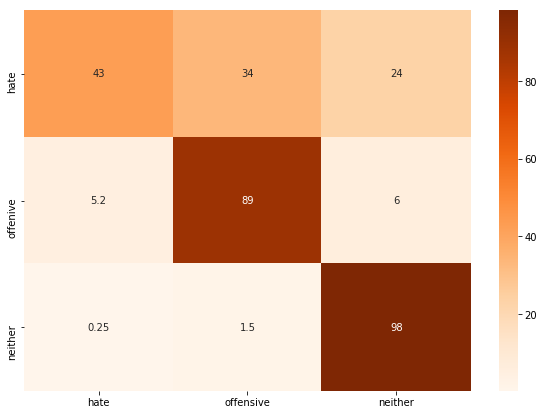

[[ 60  47  33]
 [ 26 444  30]
 [  1   6 393]]
              precision    recall  f1-score   support

           0       0.69      0.43      0.53       140
           1       0.89      0.89      0.89       500
           2       0.86      0.98      0.92       400

   micro avg       0.86      0.86      0.86      1040
   macro avg       0.81      0.77      0.78      1040
weighted avg       0.85      0.86      0.85      1040



In [21]:
forest = create_model(nbp['_min'], nbp['_max'], nbp['n_est'], nbp['mx_depth'], nbp['mn_sp'], nbp['mx_feat'])
forests.append(forest)

In [22]:
class_weight_best_params = load_pkl('tuning/tuned_parameters/random_forest/random_forest_class_weight.pkl')
cbp = class_weight_best_params
class_weight_best_params

{'_min': 0.003,
 '_max': 0.85,
 'n_est': 60,
 'mx_depth': 30,
 'mn_sp': 0.12,
 'mx_feat': 0.915}

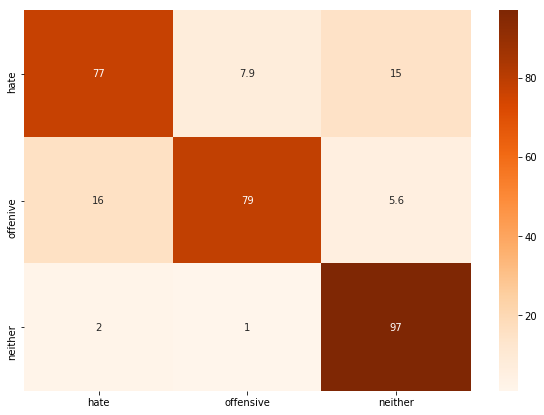

[[108  11  21]
 [ 79 393  28]
 [  8   4 388]]
              precision    recall  f1-score   support

           0       0.55      0.77      0.64       140
           1       0.96      0.79      0.87       500
           2       0.89      0.97      0.93       400

   micro avg       0.85      0.85      0.85      1040
   macro avg       0.80      0.84      0.81      1040
weighted avg       0.88      0.85      0.86      1040



In [23]:
forest_cw = create_model(cbp['_min'], cbp['_max'], cbp['n_est'], cbp['mx_depth'], cbp['mn_sp'], cbp['mx_feat'], cw = 'balanced')
forests.append(forest_cw)

In [30]:
augmented_best_params = load_pkl('tuning/tuned_parameters/random_forest/random_forest_augmented.pkl')
abp = augmented_best_params
augmented_best_params

{'_min': 0.0014818480452033042,
 'n_est': 110,
 'mx_depth': 70,
 'mn_sp': 0.11731748628002224,
 'mx_feat': 0.7547177058448401}

13500


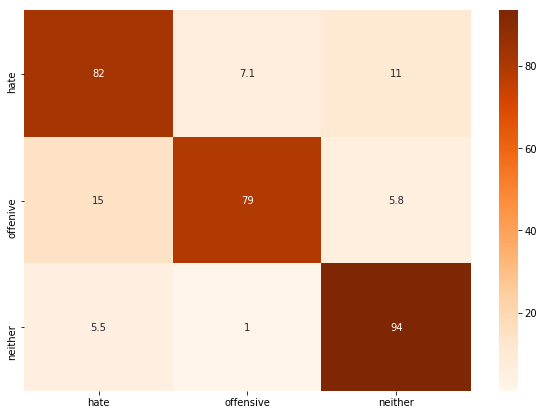

[[115  10  15]
 [ 75 396  29]
 [ 22   4 374]]
              precision    recall  f1-score   support

           0       0.54      0.82      0.65       140
           1       0.97      0.79      0.87       500
           2       0.89      0.94      0.91       400

   micro avg       0.85      0.85      0.85      1040
   macro avg       0.80      0.85      0.81      1040
weighted avg       0.88      0.85      0.86      1040



In [38]:
forest_aug = create_model(abp['_min'], 0.85, abp['n_est'],abp['mx_depth'], abp['mn_sp'], abp['mx_feat'], X = train_X2, y = train_Y2)
forests.append(forest_aug)

In [40]:
forests = [forest, forest_cw, forest_aug]
save_pkl('final_models/random_forest.pkl', forests[0])
save_pkl('final_models/random_forest_class_weight.pkl', forests[1])
save_pkl('final_models/random_forest_augmented.pkl', forests[2])